# 全局变量

In [1]:
DATASET_DIR = "/floyd/home/DataSet"
TRAIN_DIR = '{}/train'.format(DATASET_DIR)
TEST_DIR = '{}/test'.format(DATASET_DIR)
TRAIN2_DIR = '{}/train2'.format(DATASET_DIR)
TEST2_DIR = '{}/test2'.format(DATASET_DIR)

# Import Libraries

In [2]:
import os
import cv2
import h5py
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from random import choice
from keras.models import *
from keras.layers import *
from IPython.display import SVG
import matplotlib.pyplot as plt
from keras.applications import *
from sklearn.utils import shuffle
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


# 探索数据集

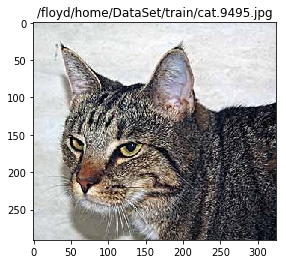

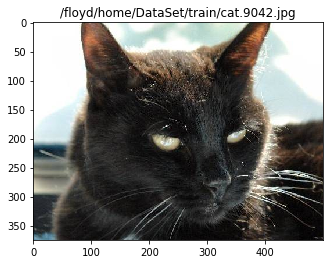

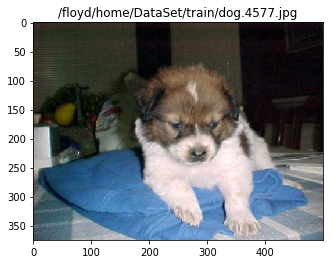

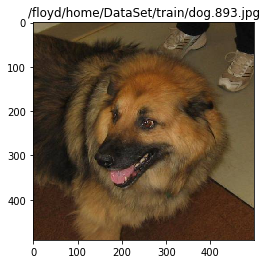

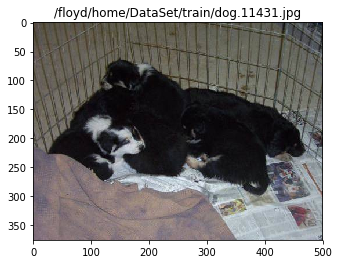

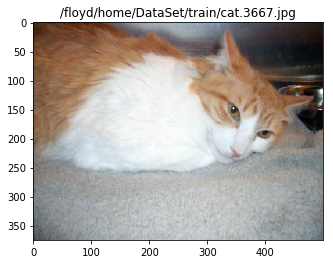

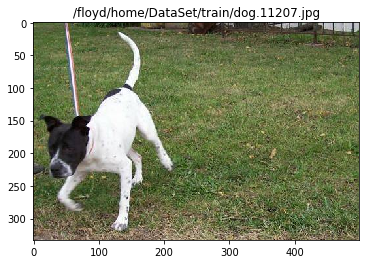

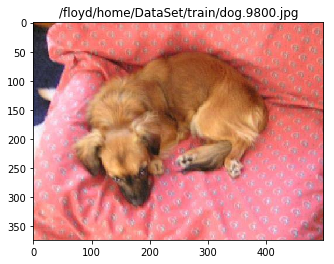

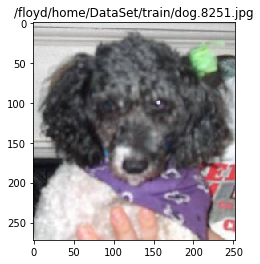

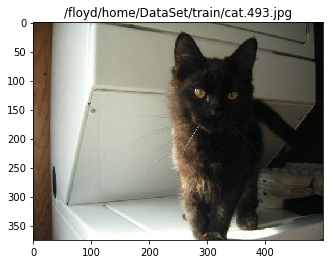

In [8]:
# 显示图片
def get_list(sdir):
    flist = os.listdir(sdir)
    List = []
    count = 10
    while count > 0:
        item = choice(flist)
        List.append(item)
        flist.remove(item)
        count -= 1
    return(List)

List = ['{}/{}'.format(TRAIN_DIR, x) for x in get_list(TRAIN_DIR)]

for pic in List:
    img = cv2.imread(pic)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    plt.imshow(rgb_img)
    plt.title(pic)
    plt.show()

* 可以看出来，数据集里有异常值，有些图片有遮挡或者过于模糊
* 这里没有选择删除异常值是因为考虑到测试集也会有异常值
* 如果删掉了训练集的异常值，模型就不能很好的学会这些异常值的处理，所以在测试集上无法做出有利于分数的预测

# 数据预处理

* 将训练集内图片分开，将猫放入一个文件夹，狗放入另一个文件夹。
* 为了不浪费磁盘空间，我们使用symlink文件描述符号的方式创建文件夹

In [5]:
os.chdir(DATASET_DIR.format(os.getcwd())) 
Train = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', Train)
train_dog = filter(lambda x:x[:3] == 'dog', Train)

os.mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

os.mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)

# 使用InceptionV3搭建模型

* InceptionV3模型设计

In [12]:
input_tensor = Input((299, 299, 3))
x = Lambda(inception_v3.preprocess_input)(input_tensor)
InceptionV3_base = InceptionV3(input_tensor = x, weights = 'imagenet', include_top = False)
InceptionV3_Model = Model(InceptionV3_base.input, GlobalAveragePooling2D()(InceptionV3_base.output))
InceptionV3_Model.summary()

87916544/87910968 [==============================] - 5s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
____________________________________________

* 加载数据

In [6]:
# 加载数据，把图片尺寸设为InceptionV3默认的(299, 299)
image_size = (299, 299)
gen = ImageDataGenerator()
train_generator = gen.flow_from_directory(TRAIN2_DIR, image_size, shuffle = False, batch_size = 16)
test_generator = gen.flow_from_directory(TEST2_DIR, image_size, shuffle = False, batch_size = 16, class_mode = None)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


* 训练保存特征向量

In [ ]:
train = InceptionV3_Model.predict_generator(train_generator, train_generator.samples)
test = InceptionV3_Model.predict_generator(test_generator, test_generator.samples)

In [ ]:
with h5py.File("gap_InceptionV3.h5") as h:
    h.create_dataset("train", data = train)
    h.create_dataset("test", data = test)
    h.create_dataset("label", data = train_generator.classes)

* 导入特征向量

In [7]:
X_train = []
X_test = []

with h5py.File("gap_InceptionV3.h5", 'r') as h:
    X_train.append(np.array(h['train']))
    X_test.append(np.array(h['test']))
    Y_train = np.array(h['label'])
    
X_train, Y_train = shuffle(X_train, Y_train)

# 搭建模型

* 使用一些默认参数搭建模型结构

In [8]:
input_tensor = Input(X_train.shape[1:])
Final_Model = Model(input_tensor, Dropout(0.5)(input_tensor))
Final_Model = Model(Final_Model.input, Dense(1, activation = 'sigmoid')(Final_Model.output))
Final_Model.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = ['accuracy'])

* 模型结构

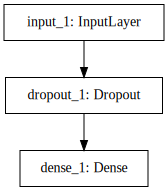

In [9]:
SVG(model_to_dot(Final_Model).create(prog='dot', format='svg'))

# 训练模型

* 先使用dropout = 0.5，optimizer = adadelta来测试

In [56]:
history = Final_Model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10, batch_size = 128)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0205 - val_acc: 0.9918
Epoch 2/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0201 - val_acc: 0.9920
Epoch 3/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0201 - val_acc: 0.9920
Epoch 4/10
20000/20000 [==============================] - 1s 54us/step - loss: 0.0147 - acc: 0.9948 - val_loss: 0.0201 - val_acc: 0.9922
Epoch 5/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.0156 - acc: 0.9947 - val_loss: 0.0200 - val_acc: 0.9924
Epoch 6/10
20000/20000 [==============================] - 1s 54us/step - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0196 - val_acc: 0.9924
Epoch 7/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0194 - val_acc:

* 画图

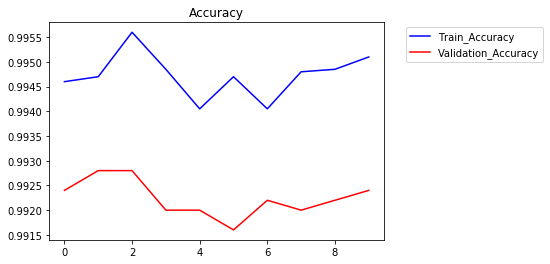

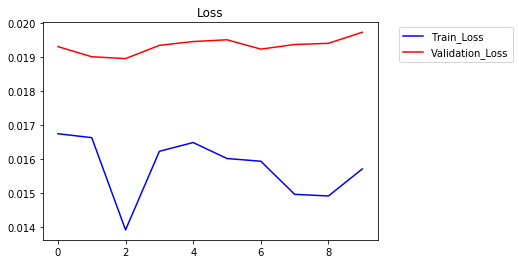

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('Accuracy')
plt.plot(range(len(acc)), acc, 'b', label = 'Train_Accuracy')
plt.plot(range(len(val_acc)), val_acc, 'r', label = 'Validation_Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.figure()
plt.title('Loss')
plt.plot(range(len(loss)), loss, 'b', label = 'Train_Loss')
plt.plot(range(len(val_loss)), val_loss, 'r', label = 'Validation_Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

* 测试不同的dropout

In [63]:
dropout_list = []
val_loss_list = []
val_acc_list = []
dropout = 0.1
while dropout <= 0.9:
    input_tensor = Input(X_train.shape[1:])
    Final_Model = Model(input_tensor, Dropout(dropout)(input_tensor))
    Final_Model = Model(Final_Model.input, Dense(1, activation = 'sigmoid')(Final_Model.output))
    Final_Model.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = Final_Model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10, batch_size = 128)  
    dropout_list.append(dropout)
    val_loss_list.append(history.history['val_loss'])
    val_acc_list.append(history.history['val_acc'])
    dropout += 0.1

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 140us/step - loss: 0.0897 - acc: 0.9754 - val_loss: 0.0345 - val_acc: 0.9890
Epoch 2/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.0285 - acc: 0.9907 - val_loss: 0.0263 - val_acc: 0.9898
Epoch 3/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.0234 - acc: 0.9924 - val_loss: 0.0236 - val_acc: 0.9904
Epoch 4/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.0202 - acc: 0.9935 - val_loss: 0.0219 - val_acc: 0.9912
Epoch 5/10
20000/20000 [==============================] - 1s 38us/step - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0208 - val_acc: 0.9916
Epoch 6/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0208 - val_acc: 0.9912
Epoch 7/10
20000/20000 [==============================] - 1s 43us/step - loss: 0.0153 - acc: 0.9952 - val_loss: 0.0202 - val_acc

* 画图比较

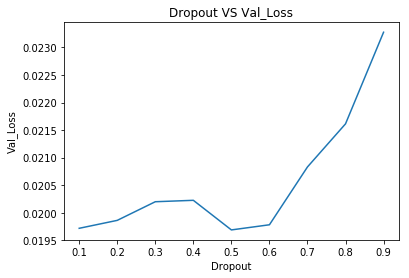

In [68]:
plt.plot(dropout_list, [x[-1:] for x in val_loss_list])
plt.title('Dropout VS Val_Loss')
plt.xlabel('Dropout')
plt.ylabel('Val_Loss')
plt.show()

可以看到dropout = 0.5的时候Val_Loss最低，所以选择dropout = 0.5

* 尝试不同的Optimizer

In [70]:
optimizer_list = ['sgd', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
val_loss_list = []
val_acc_list = []
for optimizers in optimizer_list:
    input_tensor = Input(X_train.shape[1:])
    Final_Model = Model(input_tensor, Dropout(0.5)(input_tensor))
    Final_Model = Model(Final_Model.input, Dense(1, activation = 'sigmoid')(Final_Model.output))
    Final_Model.compile(optimizer = optimizers, loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = Final_Model.fit(X_train, Y_train, validation_split = 0.2, epochs = 10, batch_size = 128)
    val_loss_list.append(history.history['val_loss'])
    val_acc_list.append(history.history['val_acc'])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 163us/step - loss: 0.1102 - acc: 0.9635 - val_loss: 0.0490 - val_acc: 0.9840
Epoch 2/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.0545 - acc: 0.9837 - val_loss: 0.0404 - val_acc: 0.9874
Epoch 3/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.0459 - acc: 0.9859 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 4/10
20000/20000 [==============================] - 1s 51us/step - loss: 0.0427 - acc: 0.9865 - val_loss: 0.0343 - val_acc: 0.9896
Epoch 5/10
20000/20000 [==============================] - 1s 38us/step - loss: 0.0397 - acc: 0.9877 - val_loss: 0.0327 - val_acc: 0.9898
Epoch 6/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.0379 - acc: 0.9881 - val_loss: 0.0315 - val_acc: 0.9898
Epoch 7/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.0362 - acc: 0.9888 - val_loss: 0.0304 - val_acc

* 画图比较

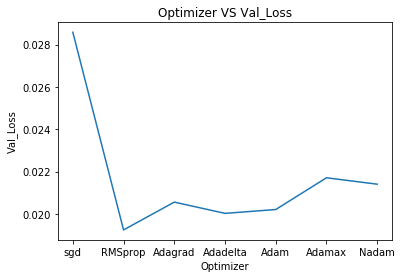

In [71]:
plt.plot(optimizer_list, [x[-1:] for x in val_loss_list])
plt.title('Optimizer VS Val_Loss')
plt.xlabel('Optimizer')
plt.ylabel('Val_Loss')
plt.show()

可以看出，RMSprop优化器表现最好，选用它

# 以最优参数训练模型

In [76]:
input_tensor = Input(X_train.shape[1:])
Final_Model = Model(input_tensor, Dropout(0.5)(input_tensor))
Final_Model = Model(Final_Model.input, Dense(1, activation = 'sigmoid')(Final_Model.output))
Final_Model.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
Final_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 训练模型
history = Final_Model.fit(X_train, Y_train, validation_split = 0.2, epochs = 15, batch_size = 128)  
val_loss_list.append(history.history['val_loss'])
val_acc_list.append(history.history['val_acc'])

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 3s 163us/step - loss: 0.0821 - acc: 0.9718 - val_loss: 0.0260 - val_acc: 0.9898
Epoch 2/15
20000/20000 [==============================] - 1s 52us/step - loss: 0.0298 - acc: 0.9901 - val_loss: 0.0229 - val_acc: 0.9904
Epoch 3/15
20000/20000 [==============================] - 1s 54us/step - loss: 0.0258 - acc: 0.9913 - val_loss: 0.0213 - val_acc: 0.9908
Epoch 4/15
20000/20000 [==============================] - 1s 51us/step - loss: 0.0241 - acc: 0.9918 - val_loss: 0.0199 - val_acc: 0.9918
Epoch 5/15
20000/20000 [==============================] - 1s 55us/step - loss: 0.0211 - acc: 0.9927 - val_loss: 0.0203 - val_acc: 0.9916
Epoch 6/15
20000/20000 [==============================] - 1s 40us/step - loss: 0.0204 - acc: 0.9932 - val_loss: 0.0196 - val_acc: 0.9922
Epoch 7/15
20000/20000 [==============================] - 1s 37us/step - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0190 - val_acc

* 可视化学习曲线

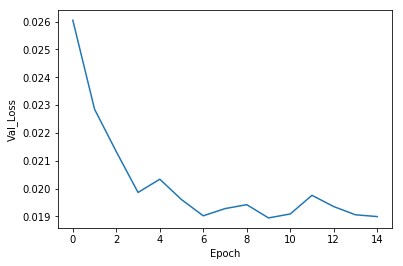

In [79]:
# val_loss学习曲线
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Val_Loss')
plt.show()

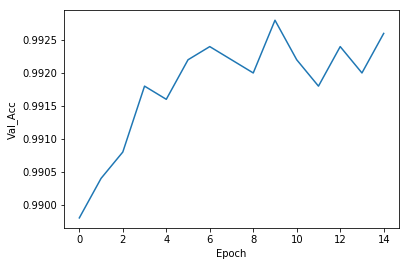

In [80]:
# Val_Acc学习曲线
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Val_Acc')
plt.show()

# 进行预测

In [89]:
y_pred = Final_Model.predict(X_test, verbose = 1)
# Clip小技巧，将每个预测值限制到[0.005, 0.995]区间内
y_pred = y_pred.clip(min = 0.005, max = 0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/') + 1:fname.rfind('.')])
    df.set_value(index - 1, 'label', y_pred[i])

df.to_csv('Submission.csv', index = None)
df.head(10)

12500/12500 [==============================] - 0s 32us/step


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
